In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv"

columns = ['age', 'year', 'nodes', 'class']

df = pd.read_csv(url, header=None, names=columns)
df

,age,year,nodes,class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


In [3]:
# verificar a distribuição de classes
# sobrevivente = 1
# não sobrevivente = 2
# Entender se o problema é de classificação desbalanceada
df['class'].value_counts(normalize=True)


class
1    0.735294
2    0.264706
Name: proportion, dtype: float64

In [4]:
# Separar os dados em X (atributos) e y (classe alvo)
X = df.drop('class', axis=1)
y = df['class']


In [5]:
# transformar as classes em 0 e 1

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [6]:
# Verificar a distribuição de classes depois do LabelEncoder
print(f"Proporção da classe 0: {np.mean(y == 0):.2%}")
print(f"Proporção da classe 1: {np.mean(y == 1):.2%}")

Proporção da classe 0: 73.53%
Proporção da classe 1: 26.47%


In [7]:
# Calcular Brier Score da baseline

# * proporção da classe positiva (classe 1)
pos_prob = np.mean(y)

# criar uma lista com a mesma probabilidade para todas as amostras
ref_probs = [pos_prob] * len(y)

# calcular o brier score da baseline
bs_ref = brier_score_loss(y, ref_probs)

print(f'Brier Score da baseline: {bs_ref:.2%}')



Brier Score da baseline: 19.46%


In [8]:
pos_prob

np.float64(0.2647058823529412)

In [9]:
# Definir a função de Brier Skill Score
def brier_skill_score(y_true, y_prob):
    pos_prob = np.mean(y_true)
    ref_probs = [pos_prob] * len(y_true)
    bs_ref = brier_score_loss(y_true, ref_probs)
    bs_model = brier_score_loss(y_true, y_prob)
    return 1.0 - (bs_model / bs_ref)

# a função tem o objetivo de medir quanto o modelo é melhor que a baseline
# se o Brier Skill Score for maior que 0, significa que o modelo é melhor que a baseline. Se for menor que 0, o modelo é pior que chutar a média
# o objetivo é criar uma métrica para avaliar modelos probabilísticos




In [10]:
# Treinar um modelo simples e calcular o Brier Skill Score (BSS)

# modelo baseline que sempre prevê a proporção da classe positiva
model = DummyClassifier(strategy='prior')

# treinar o modelo 
model.fit(X, y)

# prever probalbilidades
y_prob = model.predict_proba(X)[:,1]

# calcular o Brier Skill Score
bss = brier_skill_score(y, y_prob)

print(f'Brier Skill Score do modelo baseline: {bss:.4f}')

# O Brier Skill Score mede o quanto o modelo é melhor que a previsão da média da classe positiva.
# Se o modelo for igual a previsão previsão da média, o BSS será 0. Isso significa que o modelo não consegue prever um valor diferente de 26,47% (que é a proporção da classe positiva no seu y).
    # é um modelo "burro" que sempre chuta 26,47% como a probabilidade de um caso ser da classe positiva, para qualquer amostra que fornecermos
    # ele não aprendeu nada do dados (atributos, variável X) para fazer uma previsão inteligente 
# Se for pior, o BSS será negativo. 
# Se for melhor, o BSS será positivo.



Brier Skill Score do modelo baseline: 0.0000


In [11]:
# Função para usar no cross_val_score
def custom_brier_skill_scorer(estimator, X, y_true):
    y_prob = estimator.predict_proba(X)[:, 1]
    return brier_skill_score(y_true, y_prob)

In [12]:

# * Criar função para avaliar um modelo com validação cruzada
# o objetivo é avaliar o desempenho do modelo de forma robusta e justa
# def evaluate_model(X, y, model):
#     # divide os dados em 10 partes, repetindo 3 vezes, mantendo a proporção das classes
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     # make_scorer transforma a função brier_skill_score em uma métrica que o scikit-learn entende  
#     metric = make_scorer(brier_skill_score, needs_proba=True)
#     # cross_val_score treina e avalia o modelo em cada divisão, usando a métrica personalizada
#     # n_jobs=-1 usa todos os núcleos do processador para acelerar
#     score = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
#     return score


def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=custom_brier_skill_scorer, cv=cv, n_jobs=-1)
    return scores


In [13]:

# * Função para criar os modelos a serem testados
# criar uma lista com os modelos que serão testados
# criar uma lista com os nomes dos modelos
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(QuadraticDiscriminantAnalysis())
    names.append('QDA')
    models.append(GaussianNB())
    names.append('GNB')
    models.append(MultinomialNB())
    names.append('MNB')
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    return models, names

>LR 0.061 (0.143)
>LDA 0.063 (0.154)
>QDA 0.027 (0.221)
>GNB 0.012 (0.212)
>MNB -0.211 (0.369)
>GPC -0.143 (0.040)


C:\Users\aoliveira_esss\AppData\Local\Temp\ipykernel_18000\1226117131.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  pyplot.boxplot(results, labels=names, showmeans=True)


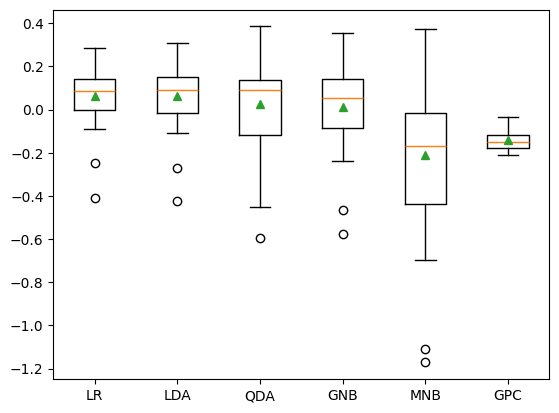

In [15]:

models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:

# * os resultados 
# LR (Regressão Logística), BSS Médio = 0.061, Desvio Padrão = 0.143. Ligeiramente melhor que a baseline, com variação moderada
# LDA (Análise Discriminante Linear), BSS Médio = 0.063, Desvio Padrão = 0.154. Similar ao LR, desempenho um pouco melhor que baseline
# QDA (Análise Discriminante Quadrática), BSS Médio = 0.027, Desvio Padrão = 0.221. Melhor que baseline mas, com alta variação
# GNB (Naive Bayes Gaussiano)	BSS Médio = 0.012, Desvio Padrão = 0.212	Quase igual à baseline, alta variabilidade
# MNB (Naive Bayes Multinomial) BSS Médio = -0.211, Desvio Padrão = 0.369	Pior que baseline, alta variabilidade — não recomendado para esse problema
# GPC (Processo Gaussiano) BSS Médio = -0.143, Desvio Padrão = 0.040	Pior que baseline, mas com baixa variabilidade


# * Sobre o boxplot
# Cada caixa representa a distribuição dos BSS para cada modelo nas 30 execuções (10 folds × 3 repetições).
# A linha laranja é a mediana.
# O triângulo verde é a média.
# Os “bigodes” mostram a variação dos resultados.
# Pontos fora dos bigodes são outliers.

# * Conclusão
# LR e LDA são os modelos mais promissores, com BSS positivos e relativamente estáveis.
# QDA e GNB têm desempenho próximo da baseline, mas com maior variação.
# MNB e GPC não são bons para esse problema, pois têm BSS negativos.